<a href="https://colab.research.google.com/github/kahxuan/chinese-calligraphy-recognition/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chinese Calligraphy Character Recognition

## Setup

In [1]:
!git clone https://github.com/kahxuan/chinese-calligraphy-ocr.git

Cloning into 'chinese-calligraphy-ocr'...
remote: Enumerating objects: 72568, done.
remote: Counting objects: 100% (72568/72568), done.
remote: Compressing objects: 100% (72431/72431), done.
remote: Total 72568 (delta 158), reused 72535 (delta 131), pack-reused 0
Receiving objects: 100% (72568/72568), 87.28 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [3]:
%cd chinese-calligraphy-ocr

/content/chinese-calligraphy-ocr


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import os
import yaml
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib as mpl
import matplotlib.pyplot as plt
from modules.model import CRModel, load_cr_model

# load config
config_path = 'config.yaml'
with open(config_path) as file:
    config = yaml.safe_load(file)

tf.config.run_functions_eagerly(True)

In [5]:
def load_dataset(data_dir, batch_size, image_size):
    return image_dataset_from_directory(data_dir, 
                                        seed=0,
                                        shuffle=True, 
                                        batch_size=batch_size, 
                                        image_size=image_size, 
                                        label_mode='categorical'
                                        )
    

def show_training_hist(history, fname=None):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(16, 4))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,2.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')

  if fname is not None:
    plt.savefig(fname)

  plt.show()

In [6]:
train = load_dataset(config['dataset']['train'], 
                     batch_size=config['model']['batch_size'], 
                     image_size=config['model']['image_size'],
                     )

val = load_dataset(config['dataset']['validation'], 
                     batch_size=config['model']['batch_size'], 
                     image_size=config['model']['image_size'],
                     )

test = load_dataset(config['dataset']['test'], 
                     batch_size=config['model']['batch_size'], 
                     image_size=config['model']['image_size'],
                     )


Found 15856 files belonging to 100 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Found 2000 files belonging to 100 classes.
Found 2000 files belonging to 100 classes.


## Train 

In [7]:
model = CRModel(num_class=config['dataset']['num_class'])
model.build(input_shape=tuple([None] + config['model']['image_size'] + [3]))

# callback functions
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=1, factor=0.5, min_lr=1e-5, verbose=1)

16711680/16705208 [==============================] - 0s 0us/step


In [8]:
if config['train']['optimizer']['name'] == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['train']['optimizer']['lr'])
elif config['train']['optimizer']['name'] == 'rmsprops':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=config['train']['optimizer']['lr'])
else:
    raise Exception('Invalid optimizer')

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

In [9]:
history = model.fit(train, validation_data=val, epochs=20, callbacks=[early_stop, rlrop])
print('\nTest:')
loss, accuracy = model.evaluate(test)

Epoch 1/20
991/991 [==============================] - 270s 241ms/step - loss: 1.9799 - accuracy: 0.5669 - val_loss: 0.8564 - val_accuracy: 0.7990
Epoch 2/20
991/991 [==============================] - 235s 237ms/step - loss: 0.6817 - accuracy: 0.8384 - val_loss: 0.5863 - val_accuracy: 0.8515
Epoch 3/20
991/991 [==============================] - 238s 240ms/step - loss: 0.4295 - accuracy: 0.8985 - val_loss: 0.5106 - val_accuracy: 0.8685
Epoch 4/20
991/991 [==============================] - 240s 242ms/step - loss: 0.2949 - accuracy: 0.9326 - val_loss: 0.4592 - val_accuracy: 0.8800
Epoch 5/20
991/991 [==============================] - 238s 240ms/step - loss: 0.2234 - accuracy: 0.9504 - val_loss: 0.4357 - val_accuracy: 0.8835
Epoch 6/20
991/991 [==============================] - 240s 242ms/step - loss: 0.1788 - accuracy: 0.9593 - val_loss: 0.4155 - val_accuracy: 0.8875
Epoch 7/20
991/991 [==============================] - 236s 238ms/step - loss: 0.1412 - accuracy: 0.9695 - val_loss: 0.3957 -

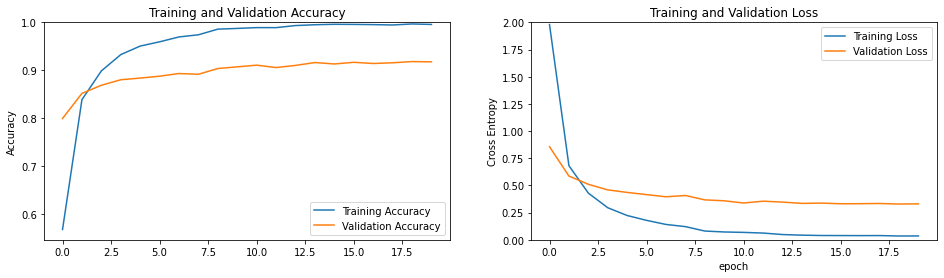

In [10]:
show_training_hist(history)

In [11]:
# model.save_weights('../drive/MyDrive/CCCR/cccr.h5')

## Evaluation

In [ ]:
weights_path = '../drive/MyDrive/CCCR/cccr.h5'
model = load_cr_model(config['model']['image_size'], weights_path)

In [12]:
# get all predictions
y_true = []
y_pred = []
images = []
data = test.as_numpy_iterator()

for step in range(len(test)):
    X, y = data.next()
    y_true += list(y)
    y_pred += list(model.predict(X))
    images += list(X)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [16]:
for k in [1, 3]:
  acc_topk = tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=k).numpy().mean()
  print('Top {} acc - {}'.format(k, acc_topk))

Top 1 acc - 0.9164999723434448
Top 3 acc - 0.9750000238418579


In [63]:
negative_labs = np.argmax(y_true[np.where(y_pred.argmax(axis=1) != y_true.argmax(axis=1))[0]], axis=1)
df = pd.DataFrame([train.class_names[x] for x in negative_labs], columns=['class'])
df['count'] = 1
df = df.groupby('class').sum()
df['acc'] = 100 - df['count'] / 20 * 100
df[df['count'] > 3].sort_values('acc')

,count,acc
class,,
只,10,50.0
看,7,65.0
美,6,70.0
他,5,75.0
发,5,75.0
能,5,75.0
后,4,80.0
如,4,80.0
得,4,80.0


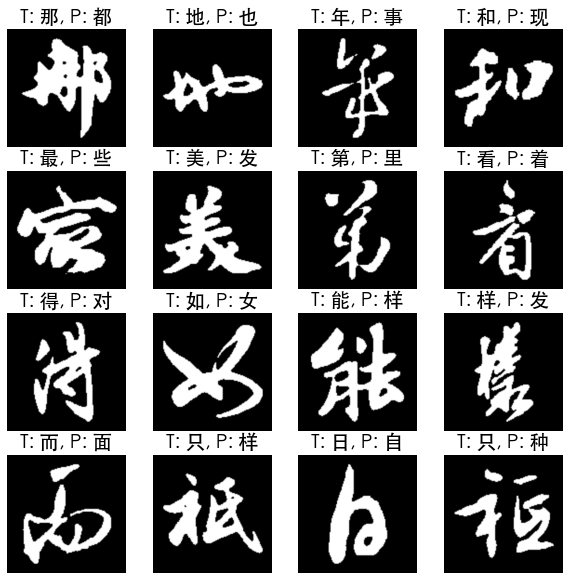

In [32]:
# show misclassfied samples
idx = np.where(y_pred.argmax(axis=1) != y_true.argmax(axis=1))[0]
random.shuffle(idx)
idx = idx[:16]

chinese_font = mpl.font_manager.FontProperties(fname='fonts/heiti.ttf')
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[idx[i]].astype("uint8"))
    name_pred = train.class_names[np.argmax(y_pred[idx[i], :])]
    name_true = train.class_names[np.argmax(y_true[idx[i], :])]
    title = 'T: {}, P: {}'.format(name_true, name_pred)
    plt.title(title, fontproperties=chinese_font, fontsize=20)
    plt.axis("off")